In [1]:
import numpy as np
import collections
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from functools import partial

from typing import List, Tuple, Callable, Dict, Hashable, Union
from functools import partial

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core import ParameterSpace
from emukit.core.interfaces import IModel
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions import (
     ExpectedImprovement as EI
)


from GPy.kern import RBF

#from transfergpbo.benchmarks import hartmann
#from transfergpbo import experiment, experiment_1
from transfergpbo import models
#from transfergpbo import benchmarks
from transfergpbo.parameters import parameters as params
from transfergpbo.models import (
    TaskData,
    WrapperBase,
    Model,
    MHGP,
    SHGP,
    BHGP,
)
from transfergpbo.models import Model

import scipy.optimize as opt
import pickle
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
#### Hartmann3d and Hartmann6d implementation #####

class benchmarks:
    @staticmethod
    def _hartmann_function(
        x: np.ndarray, alpha: np.ndarray, A: np.ndarray, P: np.ndarray
    ) -> np.ndarray:
        """The hartmann function.
    
        Parameters
        ----------
        x:
            Numerical representation of the points for which the function should be
            evaluated. shape = (n_points, n_features)
        alpha:
            The parameters of the Hartmann function. shape = (4,)
        A:
            The A-matrix, see function documentation. shape = (4, n_features)
        P:
            The P-matrix, see function documentation. shape = (4, n_features)
    
        Returns
        -------
        y:
            The function value. shape = (n_points,)
    
        """
        exponent = np.exp(
            -np.sum(A[:, :, None] * (x.T[None, :, :] - P[:, :, None]) ** 2, axis=1)
        )
        y = (-alpha[None, :] @ exponent).reshape(-1, 1)
        return y
    
    @staticmethod
    def hartmann3d_function(
        x: np.ndarray,
        alpha1: float = 1.0,
        alpha2: float = 1.2,
        alpha3: float = 3.0,
        alpha4: float = 3.2,
        output_noise: float = 0.0,
    ) -> np.ndarray:
        alpha = np.array([alpha1, alpha2, alpha3, alpha4])
        A = np.array([[3.0, 10, 30], [0.1, 10, 35], [3.0, 10, 30], [0.1, 10, 35]])
        P = 1e-4 * np.array(
            [
                [3689, 1170, 2673],
                [4699, 4387, 7470],
                [1091, 8732, 5547],
                [381, 5743, 8828],
            ]
        )
        y = benchmarks._hartmann_function(x, alpha, A, P)
        y += np.random.normal(loc=0.0, scale=output_noise, size=y.shape)
        return y
    
    @staticmethod
    def negated_hartmann3d_function(
        x: np.ndarray,
        alpha1: float = 1.0,
        alpha2: float = 1.2,
        alpha3: float = 3.0,
        alpha4: float = 3.2,
        output_noise: float = 0.0,
    ) -> np.ndarray:
        alpha = np.array([alpha1, alpha2, alpha3, alpha4])
        A = np.array([[3.0, 10, 30], [0.1, 10, 35], [3.0, 10, 30], [0.1, 10, 35]])
        P = 1e-4 * np.array(
            [
                [3689, 1170, 2673],
                [4699, 4387, 7470],
                [1091, 8732, 5547],
                [381, 5743, 8828],
            ]
        )
        y = benchmarks._hartmann_function(x, alpha, A, P)
        y += np.random.normal(loc=0.0, scale=output_noise, size=y.shape)
        return -y
    
    @staticmethod
    def hartmann3d(
        negated: bool = False,
        output_noise: float= 0.0, 
        alpha1: float = None,
        alpha2: float = None,
        alpha3: float = None,
        alpha4: float = None,
    ) -> Tuple[Callable, ParameterSpace]:
        if alpha1 is None:
            alpha1 = np.random.uniform(low=1.0, high=1.02)
        if alpha2 is None:
            alpha2 = np.random.uniform(low=1.18, high=1.2)
        if alpha3 is None:
            alpha3 = np.random.uniform(low=2.8, high=3.0)
        if alpha4 is None:
            alpha4 = np.random.uniform(low=3.2, high=3.4)
    
        if negated == True:
            return partial(
                benchmarks.negated_hartmann3d_function, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha4=alpha4
            ), ParameterSpace(
                [
                    ContinuousParameter("x1", 0.0, 1.0),
                    ContinuousParameter("x2", 0.0, 1.0),
                    ContinuousParameter("x3", 0.0, 1.0),
                ]
            )   
        else:
            return partial(
                benchmarks.hartmann3d_function, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha4=alpha4
            ), ParameterSpace(
                [
                    ContinuousParameter("x1", 0.0, 1.0),
                    ContinuousParameter("x2", 0.0, 1.0),
                    ContinuousParameter("x3", 0.0, 1.0),
                ]
            )
    @staticmethod
    def hartmann6d_function(
        x: np.ndarray,
        alpha1: float = 1.0,
        alpha2: float = 1.2,
        alpha3: float = 3.0,
        alpha4: float = 3.2,
        output_noise: float = 0.0,
    ):
        alpha = np.array([alpha1, alpha2, alpha3, alpha4])
        A = np.array(
            [
                [10, 3, 17, 3.5, 1.7, 8],
                [0.05, 10, 17, 0.1, 8, 14],
                [3, 3.5, 1.7, 10, 17, 8],
                [17, 8, 0.05, 10, 0.1, 14],
            ]
        )
        P = 1e-4 * np.array(
            [
                [1312, 1696, 5569, 124, 8283, 5886],
                [2329, 4135, 8307, 3736, 1004, 9991],
                [2348, 1451, 3522, 2883, 3047, 6650],
                [4047, 8828, 8732, 5743, 1091, 381],
            ]
        )
        y = benchmarks._hartmann_function(x, alpha, A, P)
        y += np.random.normal(loc=0.0, scale=output_noise, size=y.shape)
        return y

    @staticmethod
    def shifted_hartmann6d_function(
        x: np.ndarray,
        alpha1: float = 1.0,
        alpha2: float = 1.2,
        alpha3: float = 3.0,
        alpha4: float = 3.2,
        output_noise: float = 0.0,
    ):
        alpha = np.array([alpha1, alpha2, alpha3, alpha4])
        A = np.array(
            [
                [10, 3, 17, 3.5, 1.7, 8],
                [0.05, 10, 17, 0.1, 8, 14],
                [3, 3.5, 1.7, 10, 17, 8],
                [17, 8, 0.05, 10, 0.1, 14],
            ]
        )
        P = 1e-4 * np.array(
            [
                [1312, 1696, 5569, 124, 8283, 5886],
                [2329, 4135, 8307, 3736, 1004, 9991],
                [2348, 1451, 3522, 2883, 3047, 6650],
                [4047, 8828, 8732, 5743, 1091, 381],
            ]
        )
        y = benchmarks._hartmann_function(x, alpha, A, P)
        y += np.random.normal(loc=0.0, scale=output_noise, size=y.shape)
        return 2.5 * y + 3.25

    @staticmethod
    def hartmann6d(
        shifted: bool = False,
        output_noise: float= 0.0,
        alpha1: float = None,
        alpha2: float = None,
        alpha3: float = None,
        alpha4: float = None,
    ) -> Tuple[Callable, ParameterSpace]:
        if alpha1 is None:
            alpha1 = np.random.uniform(low=1.0, high=1.02)
        if alpha2 is None:
            alpha2 = np.random.uniform(low=1.18, high=1.2)
        if alpha3 is None:
            alpha3 = np.random.uniform(low=2.8, high=3.0)
        if alpha4 is None:
            alpha4 = np.random.uniform(low=3.2, high=3.4)
    
        if 'shifted' == True:
            return partial(
                benchmarks.shifted_hartmann6d_function, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha4=alpha4
            ), ParameterSpace(
                [
                    ContinuousParameter("x1", 0.0, 1.0),
                    ContinuousParameter("x2", 0.0, 1.0),
                    ContinuousParameter("x3", 0.0, 1.0),
                    ContinuousParameter("x4", 0.0, 1.0),
                    ContinuousParameter("x5", 0.0, 1.0),
                    ContinuousParameter("x6", 0.0, 1.0),
                ]
            )
        else:
            return partial(
                benchmarks.hartmann6d_function, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha4=alpha4
            ), ParameterSpace(
                [
                    ContinuousParameter("x1", 0.0, 1.0),
                    ContinuousParameter("x2", 0.0, 1.0),
                    ContinuousParameter("x3", 0.0, 1.0),
                    ContinuousParameter("x4", 0.0, 1.0),
                    ContinuousParameter("x5", 0.0, 1.0),
                    ContinuousParameter("x6", 0.0, 1.0),
                ]
            )


#### Experiment design ########

def generate_functions(
    ## Original function ##
    function_name: str,
    num_source_functions: int = 1,
    params_source: List[Dict[str, float]] = None,
    params_target: Dict[str, float] = None,
) -> Tuple[Callable, List[Callable], ParameterSpace]:
    """Generate the source and target functions from the respective family."""
    function = getattr(benchmarks, function_name)
    fun_target, space = ( 
        function() if params_target is None else function(**params_target)
    )   
    funs_source = []
    for i in range(num_source_functions):
        #fun, _ = function() if params_source is None else function(**params_source[i]) #hartmann3d(noised)
        fun, _ = function(shifted=True, output_noise=0.15) if params_source is None else function(**params_source[i]) #hartmann6d(shifted and noised)
        funs_source.append(fun)
    return fun_target, funs_source, space

# def generate_functions(
#     function_name: str,
#     num_source_functions: int = 1,
#     params_source: List[Dict[str, float]] = None,
#     params_target: Dict[str, float] = None,
#     ) -> Tuple[Callable, List[Callable], ParameterSpace]:
#     """Generate the source and target functions from the respective family using the negated source function hartmann3d"""
#     function = getattr(benchmark, function_name)
#     fun_target, space = (
#         function(negated=False, output_noise=0.0) if params_target is None else function(**params_target)
#     )
#     funs_source = []
#     for i in range(int(num_source_functions)):
#         fun, _ = function(negated=True, output_noise=0.15) if params_source is None else function(**params_source[i])
#         funs_source.append(fun)
#     return fun_target, funs_source, space


def get_benchmark(
    benchmark_name: str,
    num_source_points: List[int],
    num_source_functions: int,
    output_noise: float = 0.0,
    params_source: List[Dict[str, float]] = None,
    params_target: Dict[str, float] = None,
    ) -> Tuple[Callable, Dict[Hashable, TaskData], ParameterSpace]:
    """Create the benchmark object."""
    #num_source_functions = len(num_source_points)

    f_target, f_source, space = generate_functions(
        benchmark_name, num_source_functions, params_source, params_target
    )

    source_data = {}
    for i, (n_source, f) in enumerate(zip(num_source_points, f_source)):
        rand_points = space.sample_uniform(point_count=n_source)
        source_data[i] = TaskData(
            X=rand_points, Y=f(rand_points, output_noise=output_noise)
        )

    return f_target, source_data, space

def get_model(
    model_name: str, space: ParameterSpace, source_data: Dict[Hashable, TaskData]
    ) -> WrapperBase:
    """Create the model object."""
    model_class = getattr(models, model_name)
    if model_class == MHGP or model_class == SHGP or model_class == BHGP:
        model = model_class(space.dimensionality)
    else:
        kernel = RBF(space.dimensionality)
        model = model_class(kernel=kernel)
    model = WrapperBase(model)
    model.meta_fit(source_data)
    return model


##### BO campaing functions ####

def shgo_minimize(fun: Callable, search_space: ParameterSpace) -> opt.OptimizeResult:
    """Minimize the benchmark with simplicial homology global optimization, SHGO

    Original paper: https://doi.org/10.1007/s10898-018-0645-y

    Parameters
    -----------
    fun
        The function to be minimized.
    search_space
        Fully described search space with valid bounds and a meaningful prior.

    Returns
    --------
    res
        The optimization result represented as a `OptimizeResult` object.
    """

    def objective(x):
        benchmark_value = fun(np.atleast_2d(x), output_noise=0.0)
        return benchmark_value.squeeze()

    bounds = search_space.get_bounds()
    return opt.shgo(objective, bounds=bounds, sampling_method="sobol")


def run_bo(
    experiment_fun: Callable,
    model: Union[Model, IModel],
    space: ParameterSpace,
    num_iter: int,
    noiseless_fun: Callable = None,
):
    """Runs Bayesian optimization."""

    if noiseless_fun:
        f_min = shgo_minimize(noiseless_fun, space).fun
    else:
        f_min = None

    regret = []
    for i in range(num_iter):
       

        if i == 0:  # sample a random point for the first experiment
            X_new = space.sample_uniform(1)
            Y_new = experiment_fun(X_new)
            X, Y = X_new, Y_new
        else:  # optimize the AF
            af = EI(model) #UCB(model, beta=np.float64(3.0)) # \beta is too big
            optimizer = GradientAcquisitionOptimizer(space)
            X_new, _ = optimizer.optimize(af)
            Y_new = experiment_fun(X_new)
            X = np.append(X, X_new, axis=0)
            Y = np.append(Y, Y_new, axis=0)

       
        model.fit(TaskData(X, Y), optimize=True)

        if f_min is not None:
            f_observed = experiment_fun(X, output_noise=0.15)
            f_min_observed = np.min(experiment_fun(X, output_noise=0.15))
            regret.append((f_min_observed - f_min).item())

   
    return f_observed

#### Experiment function ######

def run_tl_bo(
    params_dict: dict
)-> List[float]:
    technique = params_dict['technique']
    benchmark_name = params_dict['benchmark']['benchmark_name']
    num_steps = params_dict['benchmark']['num_steps']
    num_source_points = params_dict['benchmark']['num_source_points']
    num_source_functions = params_dict['benchmark']['num_source_functions']
    output_noise = params_dict["output_noise"]
    params_source = params_dict["benchmark"].get("parameters_source", None)
    params_target = params_dict["benchmark"].get("parameters_target", None)
    
    f_target, source_data, space = get_benchmark(
        benchmark_name=benchmark_name, 
         num_source_points=num_source_points, 
         num_source_functions=num_source_functions, 
         output_noise=output_noise,
         params_source=params_source, 
         params_target=params_target
    )
    
    model = get_model(technique, space, source_data)
    
    return run_bo(
            experiment_fun=partial(f_target, output_noise=output_noise),
            model=model,
            space=space,
            num_iter=num_steps,
            noiseless_fun=partial(f_target, output_noise=0.0)
    )

def run_experiments(
    technique: str,
    parameter_dict: Dict
)->Tuple:
    
    parameter_dict['technique'] = technique
    output = collections.defaultdict(list)
    np.random.seed(45)
    seed = [np.random.randint(1, 500) for i in range(50)]

    for i, s in tqdm(zip(range(50), seed), total=50, desc=technique):
        np.random.seed(s)
        try:
            output['iterations'].append(i)
            output['f_observed'].append(run_tl_bo(parameter_dict))
        except:
            output['iterations'].append(i)
            output['f_observed'].append(np.zeros((10,1)))

    
    f_observed = np.array([i for i in output['f_observed'] if not np.all(i == 0)])
    f_observed_mean = np.mean(f_observed, dtype=np.float64, axis=0)
    f_observed_stderr = np.std(f_observed, dtype=np.float64, axis=0) / np.sqrt(f_observed_mean.shape[0])
        

    
    return f_observed, f_observed_mean, f_observed_stderr
    
### Plotting function #####

def plot_means_and_errors(result_dict):
    plt.figure(figsize=(10, 8))

    for key, values in result_dict.items():
        if 'mean' in key:
            technique_name = key.replace('_mean', '')
            mean_array = values
            stderr_array = result_dict.get(f'{technique_name}_stderr', np.zeros_like(mean_array))
            
            x_values = np.arange(1,len(mean_array)+1)
            
            sns.lineplot(x=x_values, y=mean_array, label=f'{technique_name}', marker='o')
            plt.fill_between(x=x_values, y1=mean_array - stderr_array, y2=mean_array + stderr_array, alpha=0.25)
  
    plt.xlabel('BO_Iteration')
    plt.ylabel('f_observed')
   
    plt.legend(loc='best')
    plt.show()



In [145]:
# np.random.seed(1)
# #print(f'{benchmark.hartmann3d(negated=False, output_noise=0.10)}\n{benchmark.hartmann3d(negated=True, output_noise=0.15)}')
# generate_functions('hartmann6d', 1)
# get_benchmark(benchmark_name='hartmann6d', num_source_points= [9], num_source_functions=1, output_noise=0.0)

In [4]:
params = {
    "technique" : 'SHGP',
    "benchmark" : {
            "benchmark_name" : 'hartmann6d',
            "num_source_points" : [9],
            "num_source_functions" : 1,
            "num_steps" : 10, # 10 for hartmann3d and 25 for hartmann6d
            "parameters_source" : None,
            "parameters_target" : None
    },
    "output_noise" : 0.15
}

technique_list = ['GPBO', 'SHGP', 'BHGP', 'MHGP', 'HGP', 'MTGP', 'RGPE', 'WSGP']

In [5]:


#technique_list = ['GPBO', 'SHGP', 'BHGP']
source_points_list = [15, 24, 36, 45, 51, 60] #number of source points * dimensionality of the family functions
results_dict = {}
array_dict = {}

for technique in tqdm(technique_list):
    if technique == 'GPBO':
        f_obs_array, mean, stderr = run_experiments(technique, params)
        array_dict[f'{technique}_f_observed'] = f_obs_array
        results_dict[f'{technique}_mean'] = mean
        results_dict[f'{technique}_stderr'] = stderr
    else:
        for s in tqdm(source_points_list, desc=f'{technique}'):
            params['benchmark']['num_source_points'] = [s]
            f_obs_array, mean, stderr = run_experiments(technique, params)
            array_dict[f'{technique}_{s}_f_observed'] = f_obs_array
            results_dict[f'{technique}_{s}_mean'] = mean
            results_dict[f'{technique}_{s}_stderr'] = stderr


  0%|          | 0/8 [00:00<?, ?it/s]

GPBO:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/6 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

SHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/6 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

BHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/6 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

MHGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/6 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

HGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/6 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

MTGP:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/6 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

RGPE:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/6 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

WSGP:   0%|          | 0/50 [00:00<?, ?it/s]

> The source points are: N*dim_{family}; where N are the source points, [1,2,3,5,8,20] and dim_{family}= 3, since I'm using Hartmann3d.

> The params dictionary fixes the number of source functions to 1. It could be modified.

> The source model has noise of \sigma=0.15 and the target is the noisless version oh the Hartmann3d function. This can be modified.

> Only the SHGP and BHGP are used. GPBO is the model with no source points, equivalent to 0 %. 

In [6]:
file_1 = './results_dict_all_models_hartmann6_5-20.pkl'
file_2 = './results_dict_arrays_aall_hartmann6_5-20.pkl'

with open(file_1, 'wb') as file:
    pickle.dump(results_dict, file)

with open(file_2, 'wb') as f:
    pickle.dump(array_dict, f)

## Transfergpbo upload for hartmann3d and hartmann6d:

In [133]:
### Low points regime ###
# file_a = './results_dict_all_models_.pkl'
# file_b = './results_dict_arrays_aall.pkl'
# file_c_1 = './results_dict_all_models_hartmann6_.pkl'
# file_c = './results_dict_arrays_aall_hartmann6.pkl'

## high points regime ###
file_a = './results_dict_all_models_hartmann3_5-20.pkl'
file_b = './results_dict_arrays_aall_hartmann35-20.pkl'
file_c_1 = './results_dict_all_models_hartmann6_5-20.pkl'
file_c = './results_dict_arrays_aall_hartmann6_5-20.pkl'


with open(file_a, 'rb') as file:
    loaded_array_a = pickle.load(file)
    
with open(file_b, 'rb') as file1:
    loaded_array_b = pickle.load(file1)

with open(file_c_1, 'rb') as file2:
    loaded_array_c1 = pickle.load(file2)

with open(file_c, 'rb') as file3:
    loaded_array_c = pickle.load(file3)

In [28]:
# files_list = ['./results_dict_all_models_.pkl', 
#               './results_dict_arrays_aall.pkl',
#               './results_dict_all_models_hartmann6_.pkl',
#               './results_dict_arrays_aall_hartmann6.pkl'
#              ]

# for file_path in files_list:
#     try:
#         with open(file_path, 'rb') as f:
#             data = pickle.load(f)
#             all_data.append(data)
#     except Exception as e:
#         print(f"Error loading file {file_path}: {e}")

HARTMANN3d
model-wise


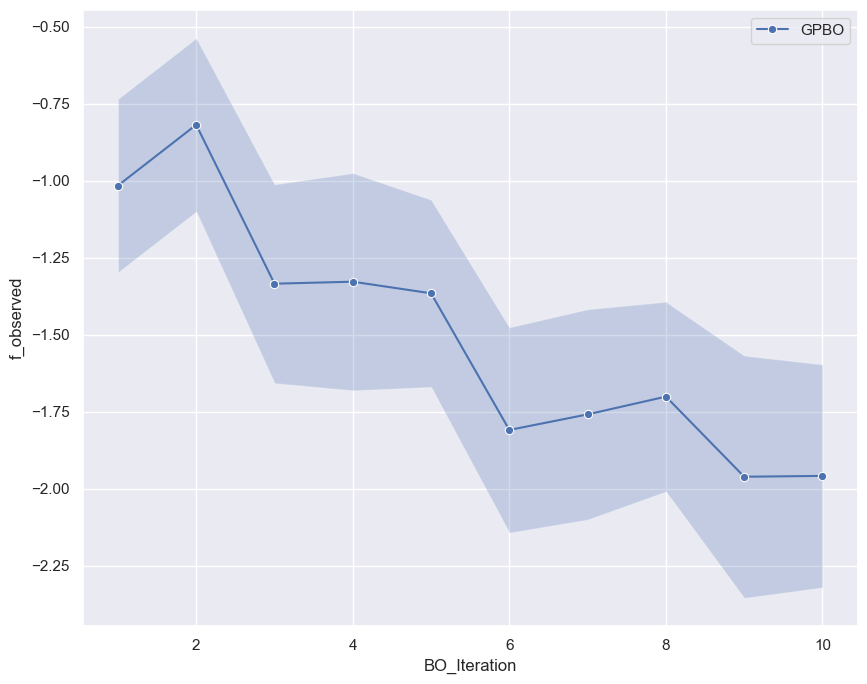

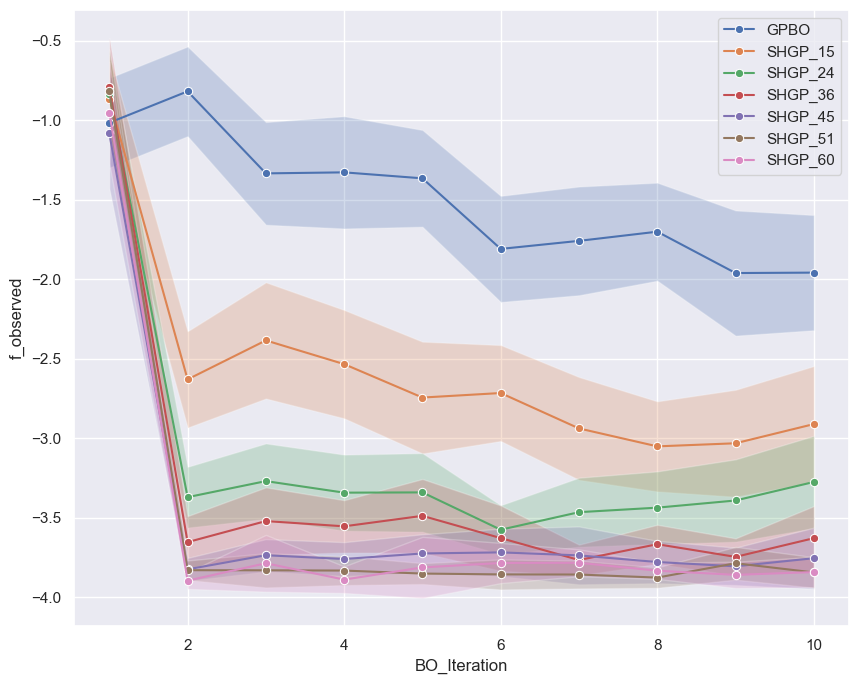

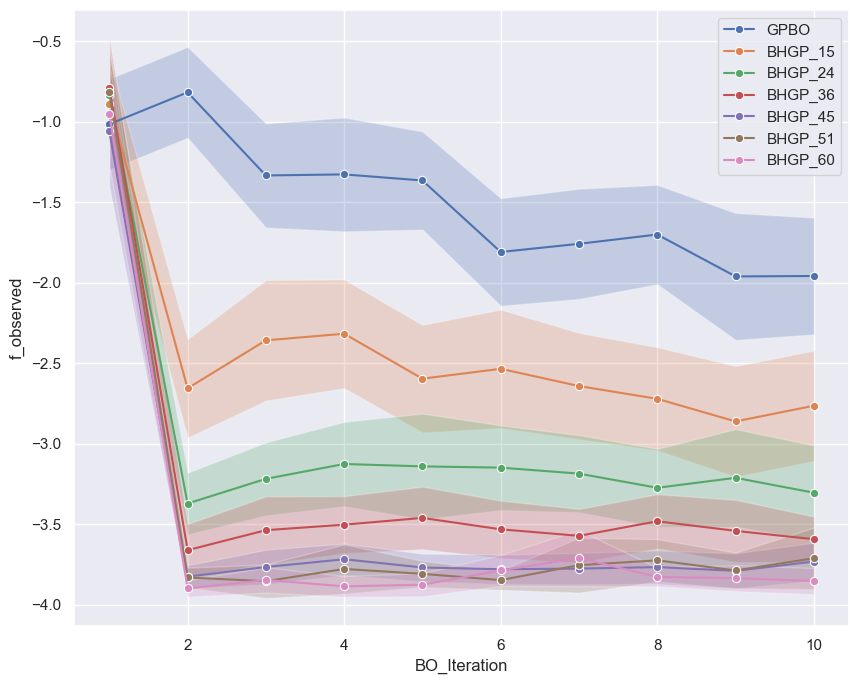

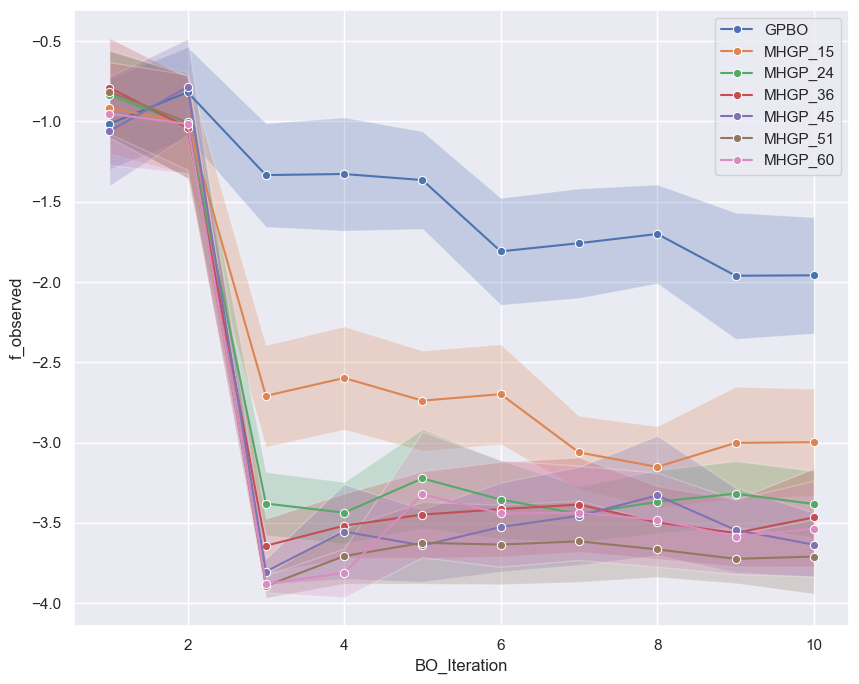

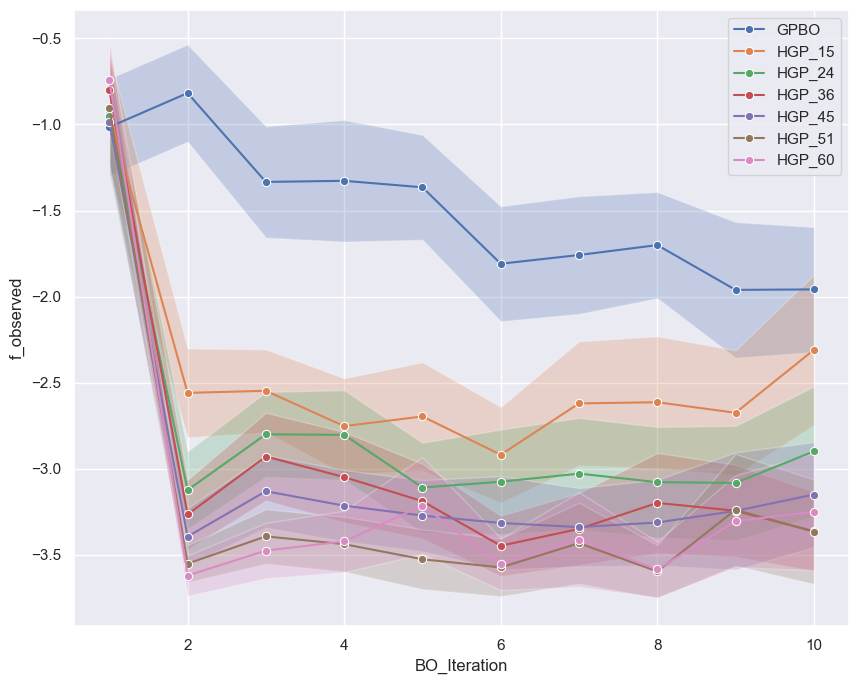

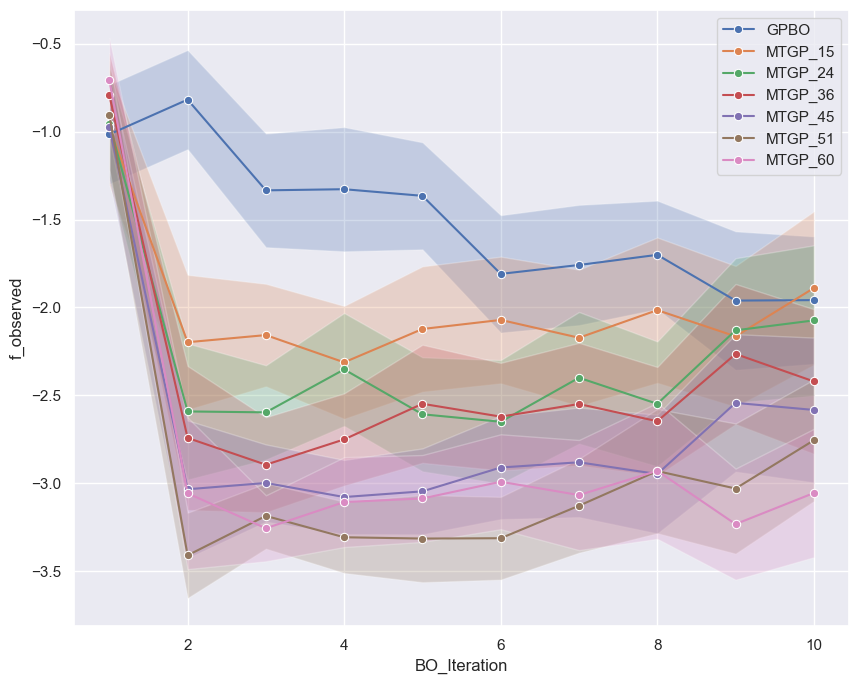

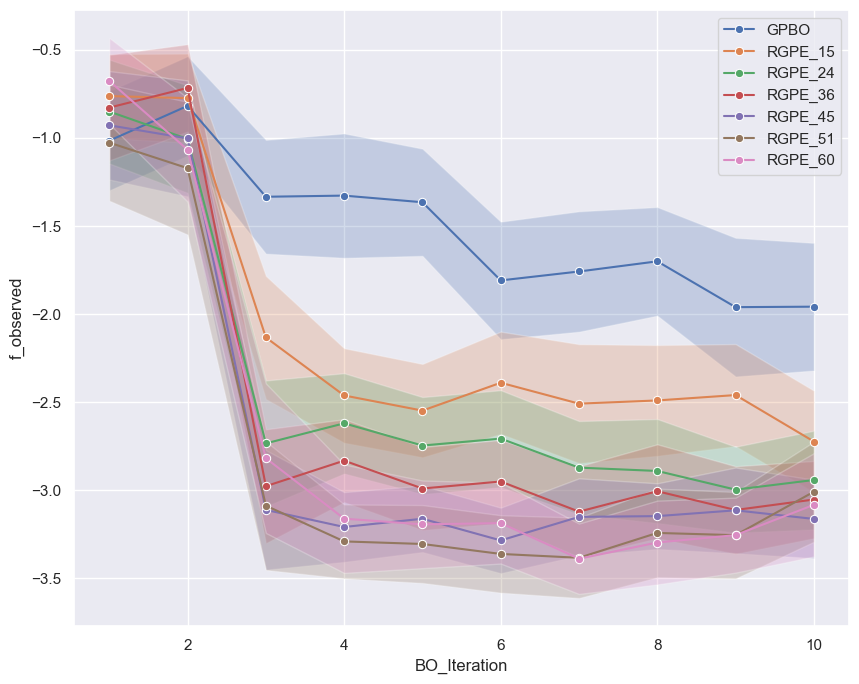

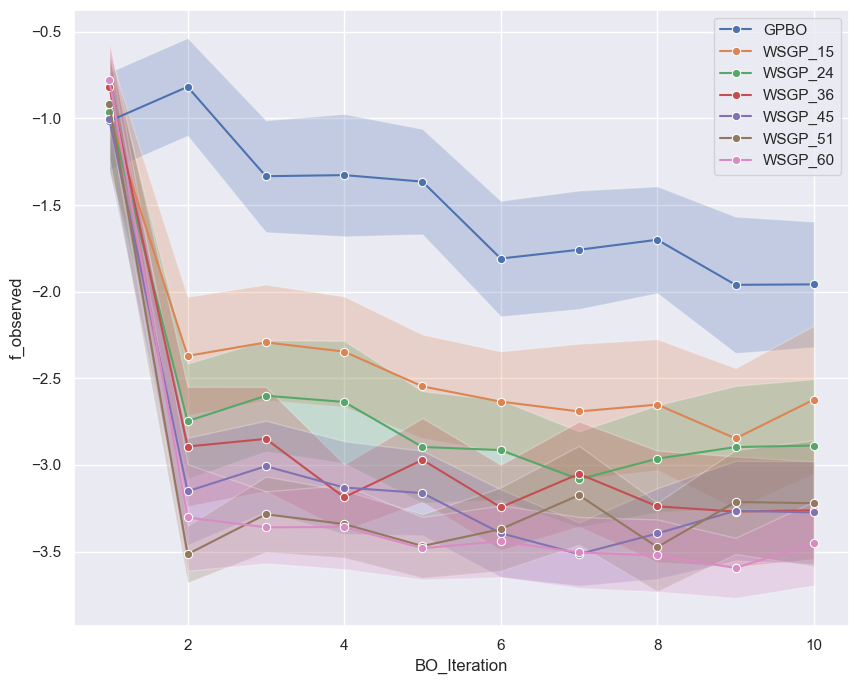

In [81]:
print('HARTMANN3d')
print('model-wise')
for i in technique_list:
    if i == 'HGP':
        plot_means_and_errors({k : v.flatten() for k,v in loaded_array_a.items() if any(s in k for s in ['GPBO', i]) and 
                  not k.startswith(('S', 'B', 'M'))})
    else:
        plot_means_and_errors({k : v.flatten() for k,v in loaded_array_a.items() if any(s in k for s in ['GPBO', i])})

HARTMANN3d
source_points-wise


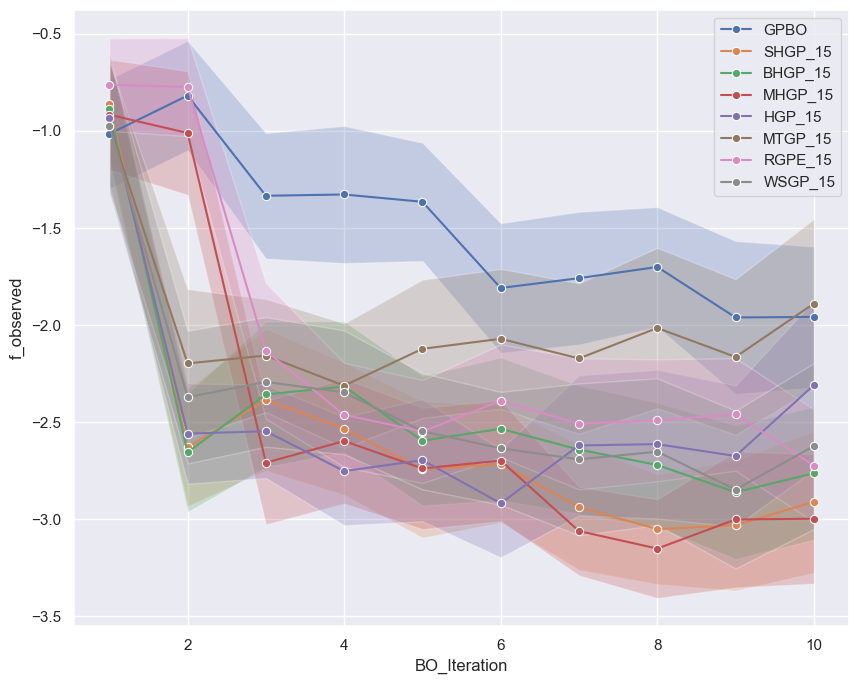

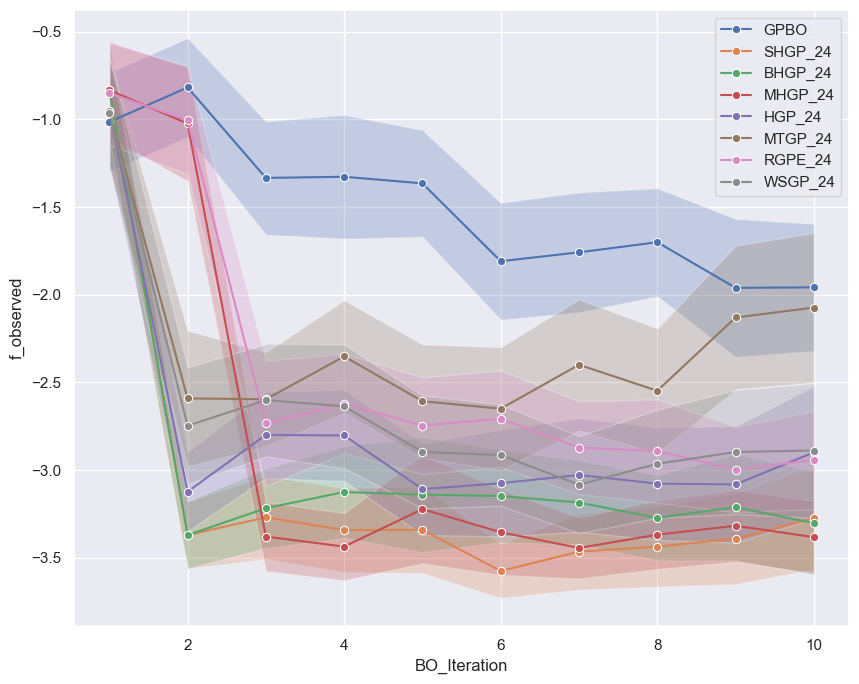

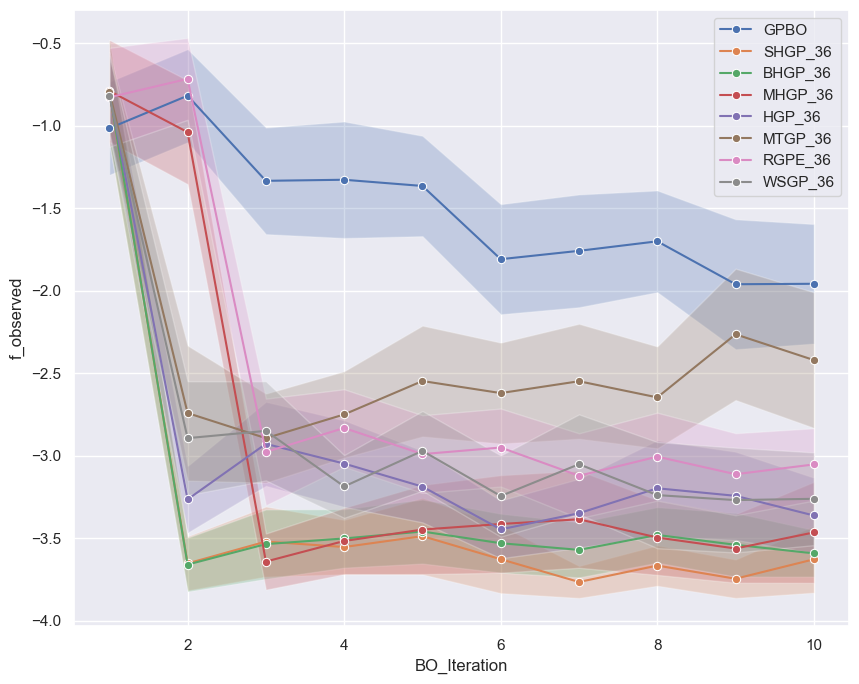

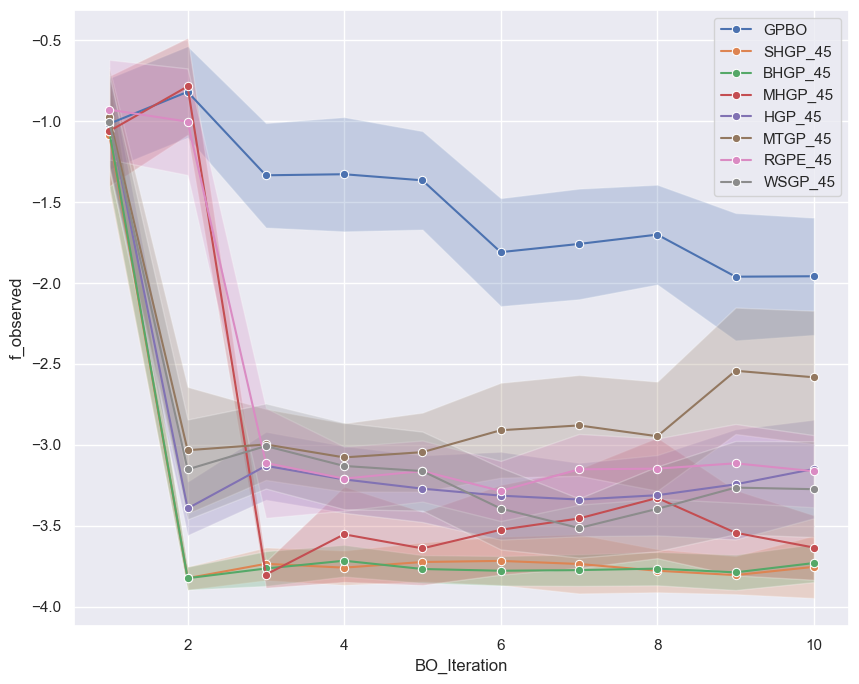

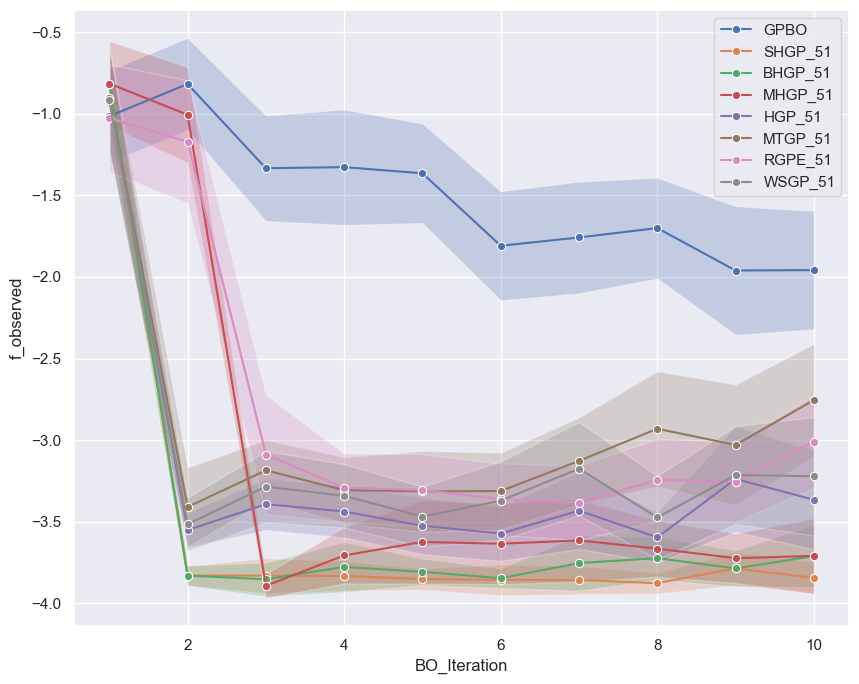

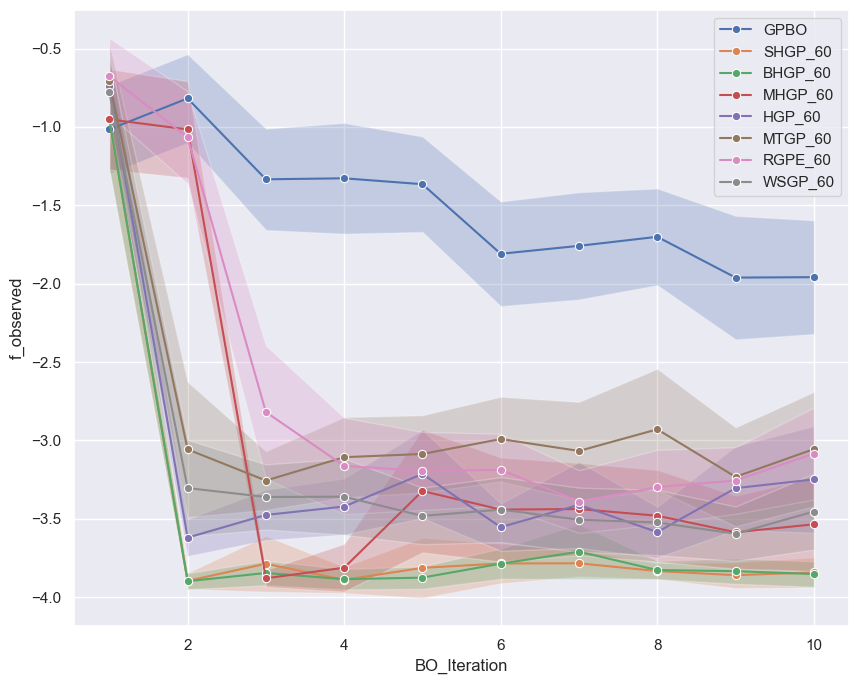

In [82]:
print('HARTMANN3d')
print('source_points-wise')
for i in source_points_list:
    plot_means_and_errors({k : v.flatten() for k,v in loaded_array_a.items() if any(s in k for s in ['GPBO', str(i)])})


HARTMANN6d
model-wise


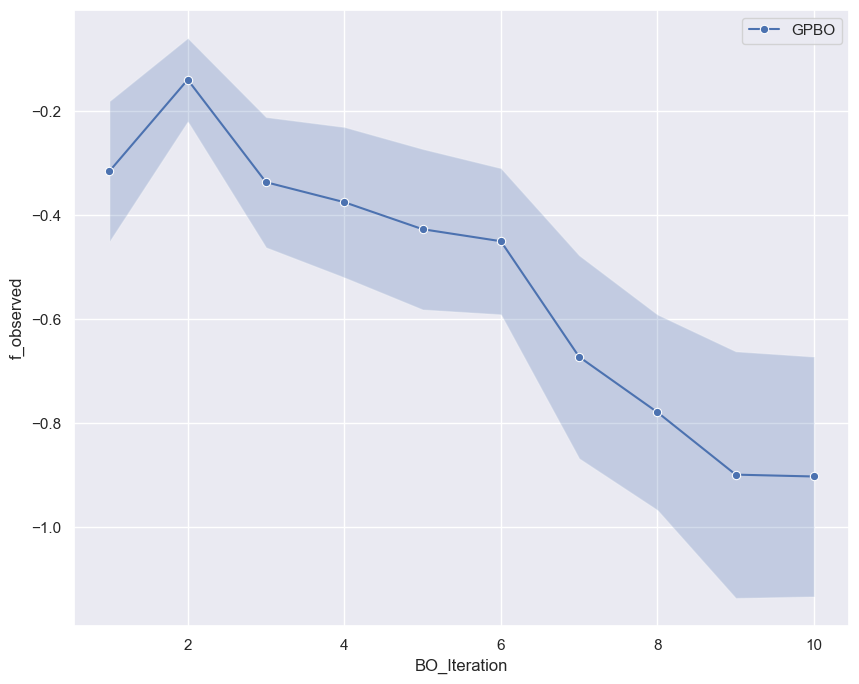

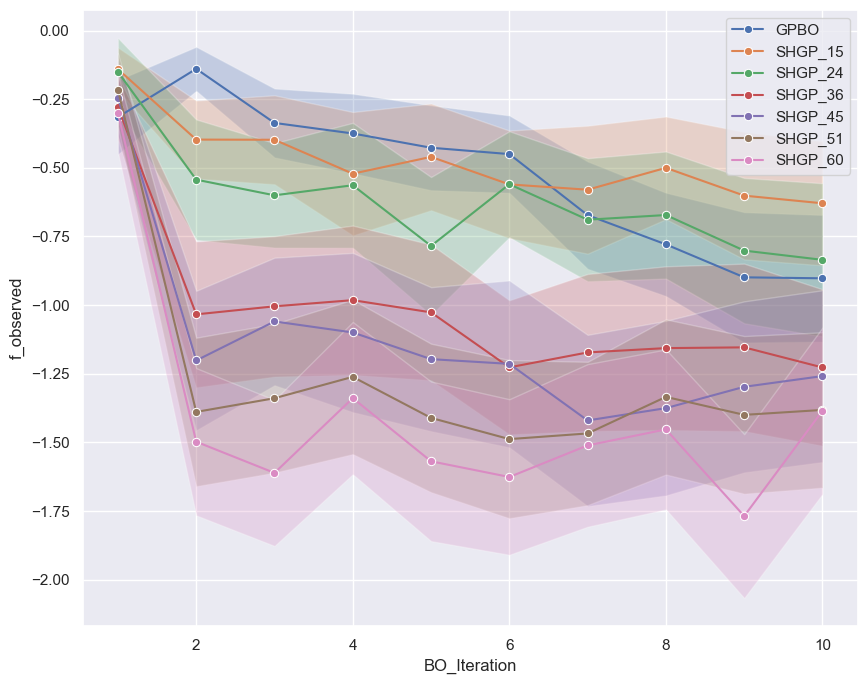

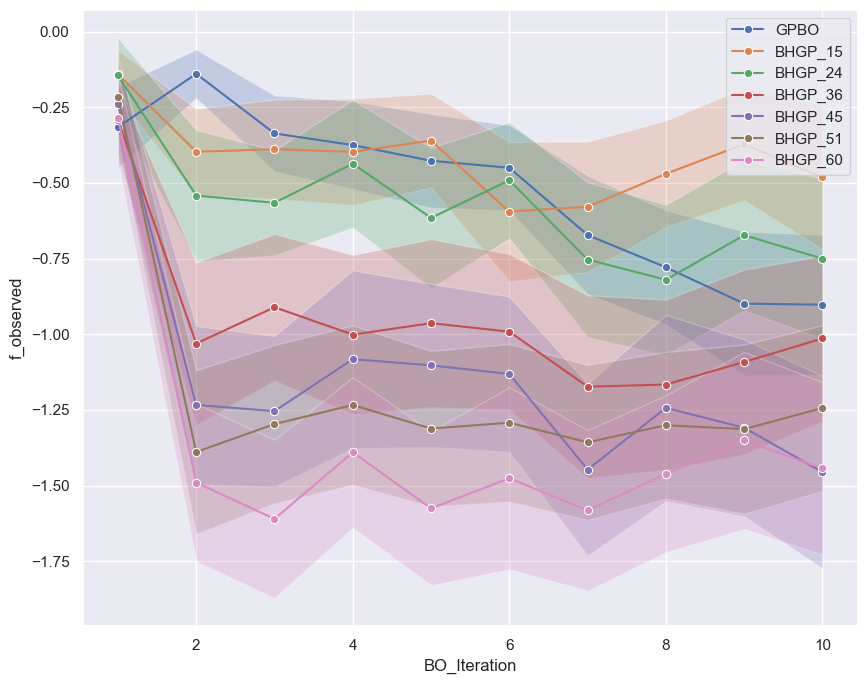

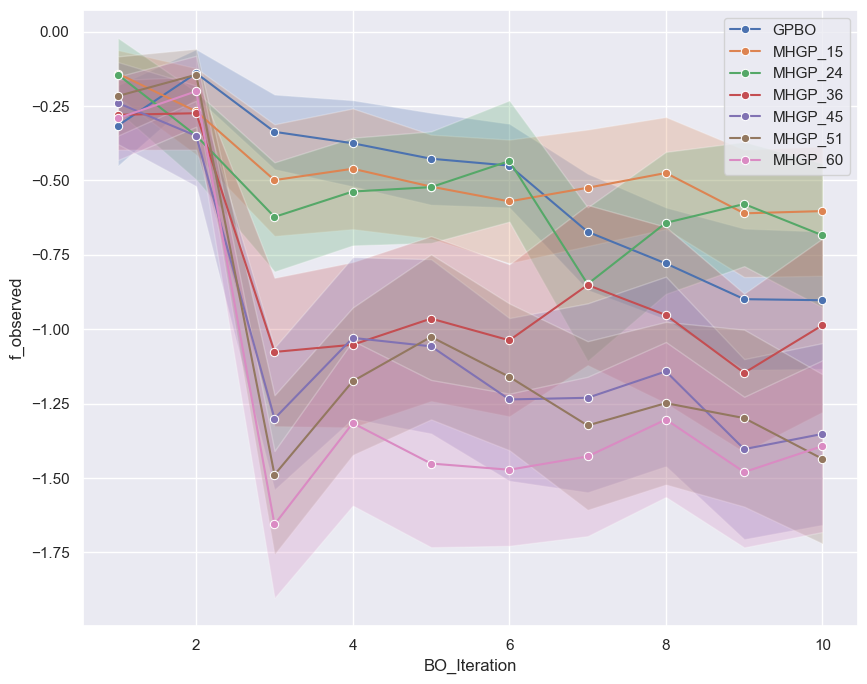

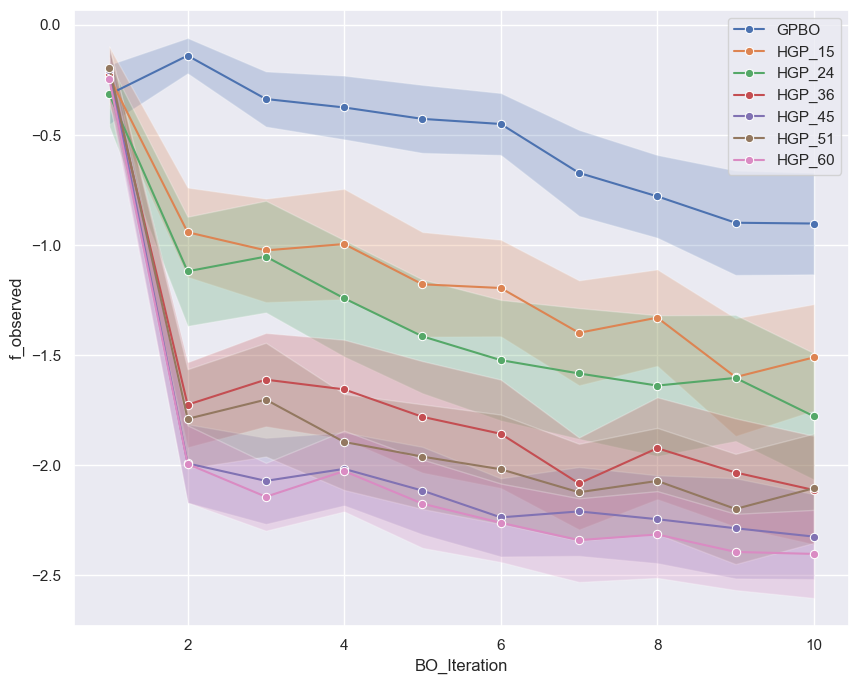

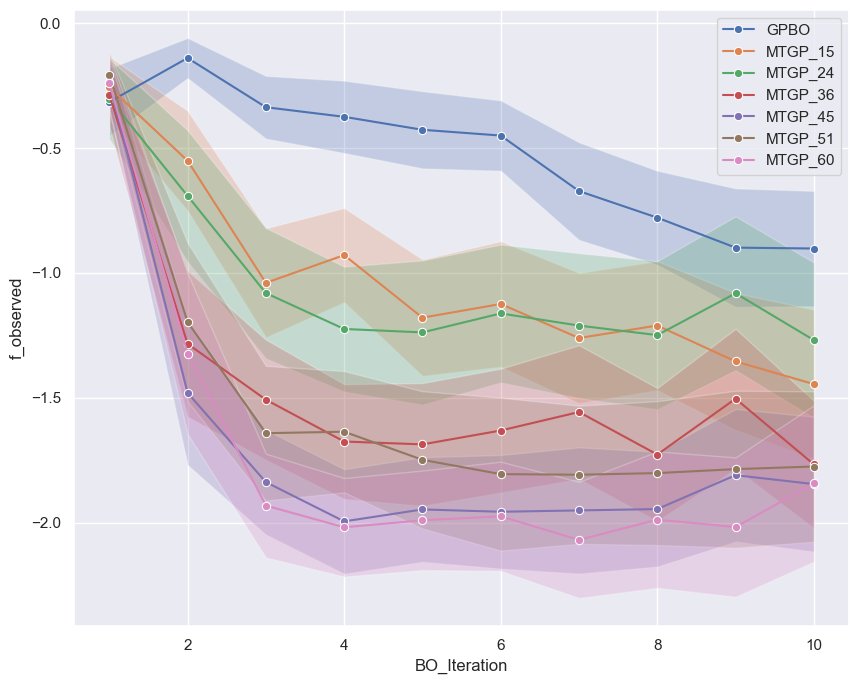

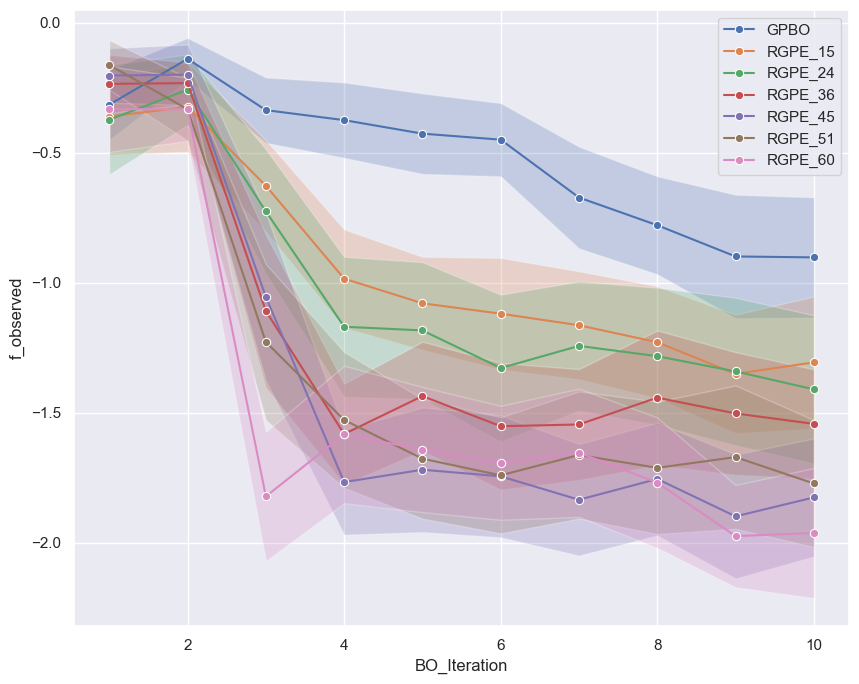

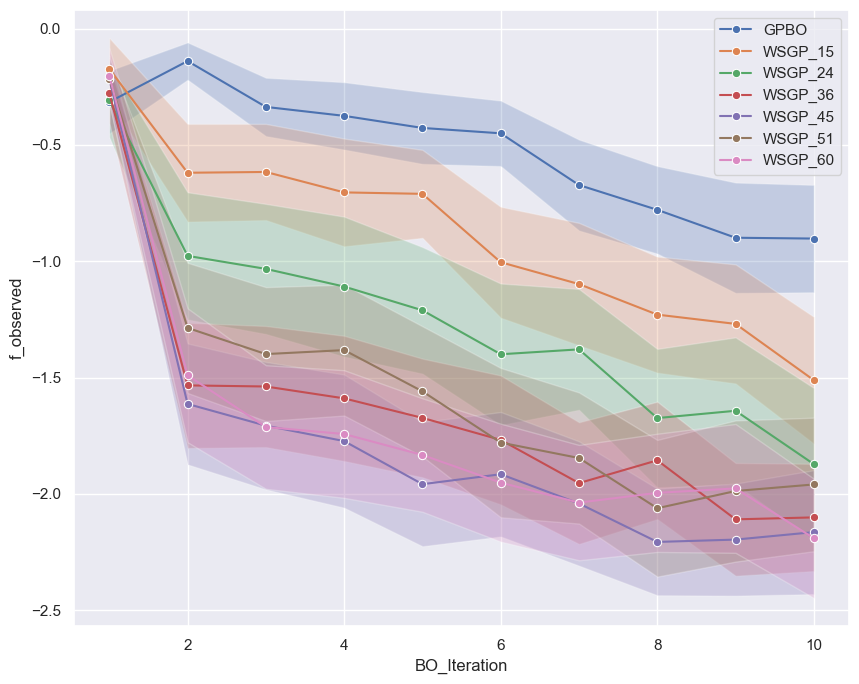

In [83]:
print('HARTMANN6d')
print('model-wise')
for i in technique_list:
    if i == 'HGP':
        plot_means_and_errors({k : v.flatten() for k,v in loaded_array_c1.items() if any(s in k for s in ['GPBO', i]) and 
                  not k.startswith(('S', 'B', 'M'))})
    else:
        plot_means_and_errors({k : v.flatten() for k,v in loaded_array_c1.items() if any(s in k for s in ['GPBO', i])})

HARTMANN6d
source_points-wise


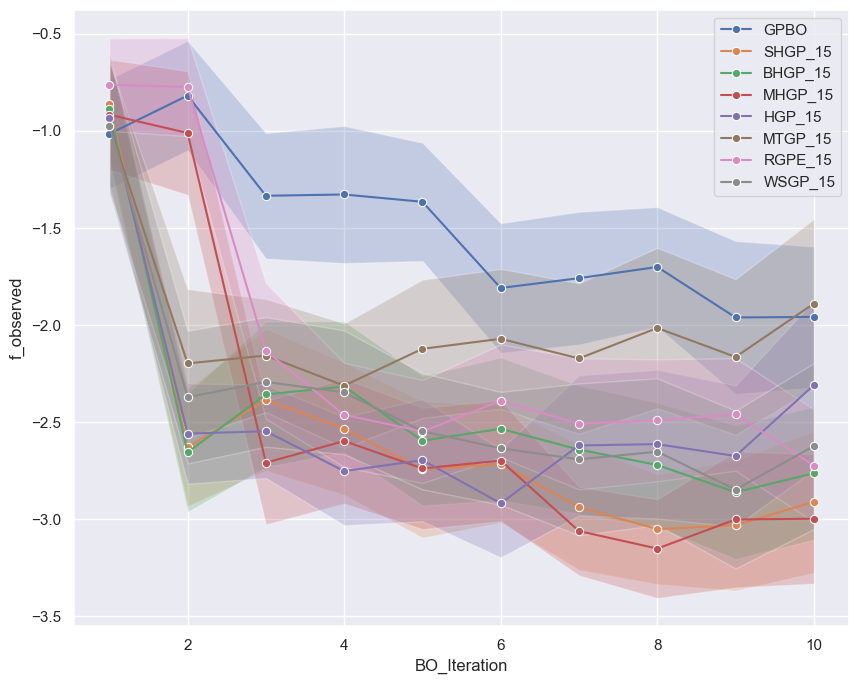

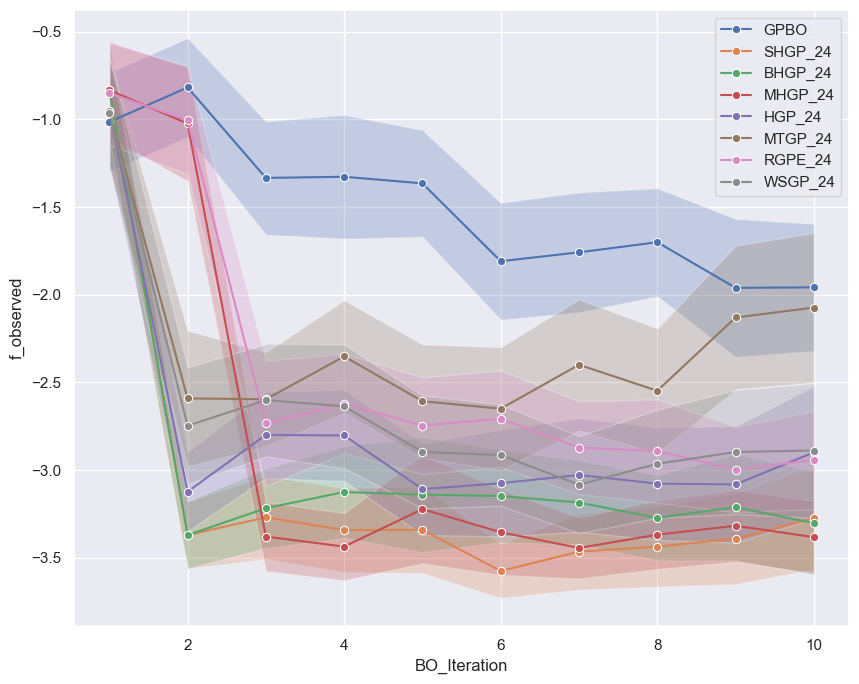

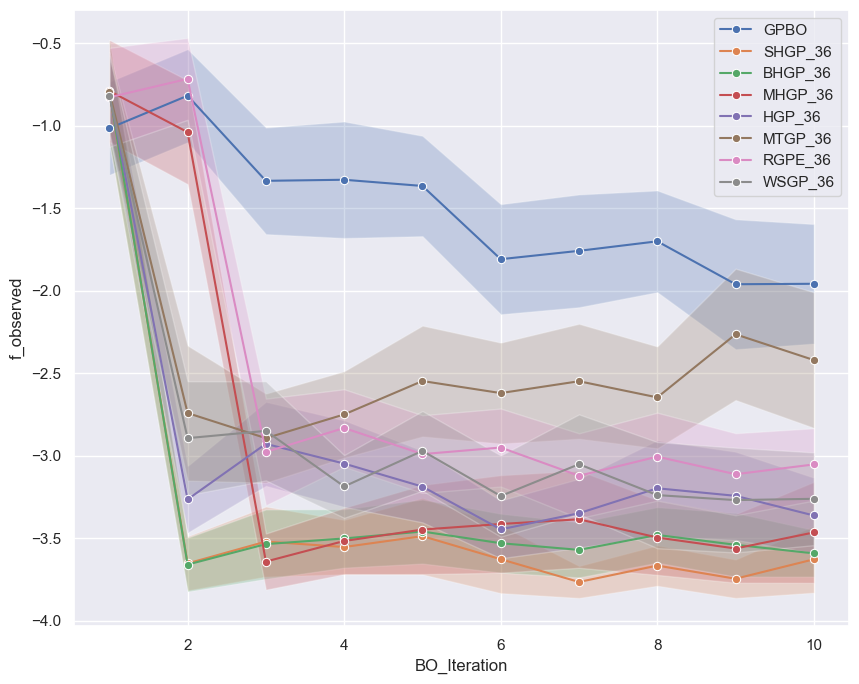

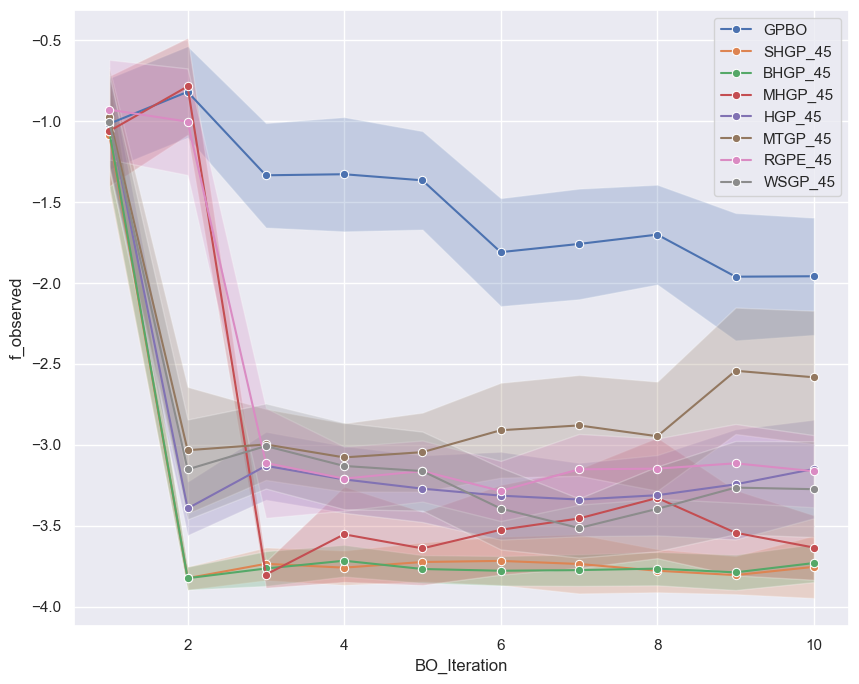

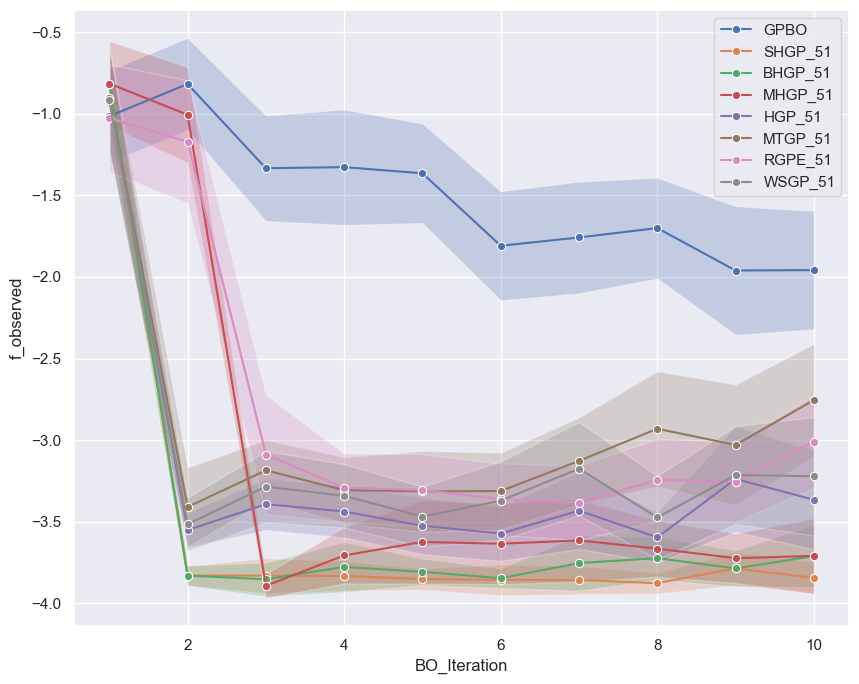

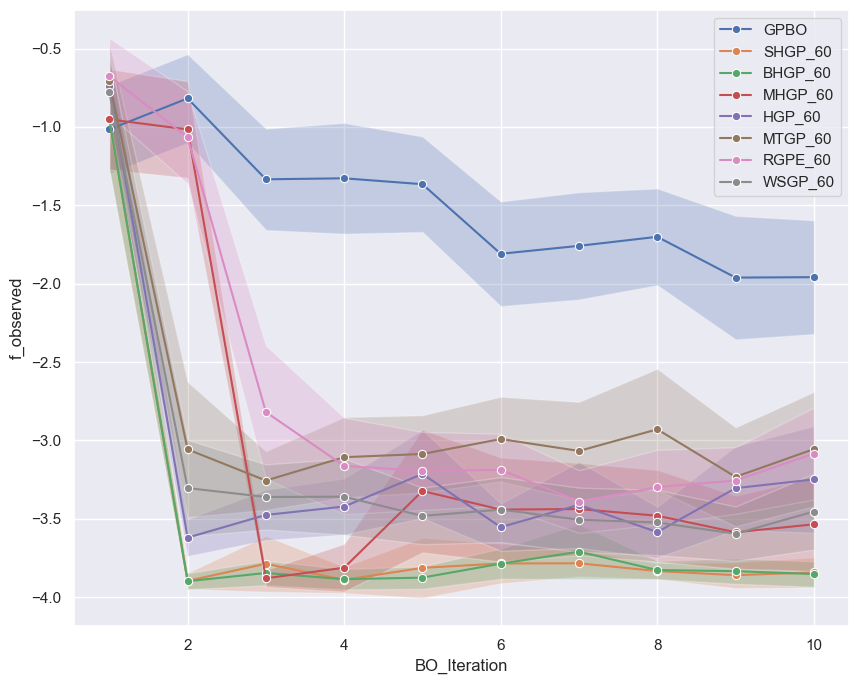

In [84]:
print('HARTMANN6d')
print('source_points-wise')
for i in source_points_list:
    plot_means_and_errors({k : v.flatten() for k,v in loaded_array_a.items() if any(s in k for s in ['GPBO', str(i)])})


## Comparison between transfergpbo and baybe

In [181]:
## Functions to make compatible baybe and transfergpbo outputs

def pad_arrays(dictionary, desired_shape=(50, 10, 1)):
    padded_dict = {}
    for key, array in dictionary.items():
        padding_needed = [(0, desired_shape[i] - array.shape[i]) for i in range(len(desired_shape))]
        padded_array = np.pad(array, padding_needed, mode='constant', constant_values=np.nan)
        padded_dict[key] = padded_array
    return padded_dict



def create_dataframes(paded_dict): 
    # keyword_mapping = {'GPBO': 0, '3': 1, '6': 2, '15': 5, '24': 8,  '60': 20} # low number of source points
    keyword_mapping = {'GPBO': 0, '15': 5, '24': 8, '36': 12, '45': 15, '51':17, '60': 20} # hihg number of source points
    
    #{prefix.split('_f')[0]: idx for idx, (prefix, _) in enumerate(sorted(paded_dict.items()))}

    dataframes = {}

    for k, v in paded_dict.items():
        prefix = k.split('_f')[0].split('_')[-1]
        value = keyword_mapping.get(prefix, -1)
        if value != -1:
            df = pd.DataFrame({
                'percentage_data_used': [value for _ in range(500)],
                'iteration': [i % 10 for i in range(50 * 10)],
                'number_of_experiments': [i % 10 + 1 for i in range(50 * 10)],
                'f_measured': v.flatten().tolist()
            })
            dataframes[k] = df  

    # Concatenate all dataframes into a single dataframe
    concatenated_df = pd.concat(dataframes.values(), ignore_index=True)

    return concatenated_df



### Baybe csv upload and plots:

In [149]:
file = '/Users/martinmejia/Desktop/baybe_continuous_snapshots/5-20/baybe_continous_results_trgpbo_50.csv'
baybe_df = pd.read_csv(file)
baybe_df = baybe_df.rename(columns={"Num. clusters":"num_clusters", 
                        "Iteration":"iteration", 
                        "Num_Experiments":"number_of_experiments",
                        "Target_CumBest":"f_measured"})

print(f'baybe_df shape: {baybe_df.shape}')
baybe_df.head()

baybe_df shape: (3000, 8)


num_clusters  Random_Seed  Initial_Data  iteration  number_of_experiments  \
0            5         1337           0.0          0                      1   
1            5         1337           0.0          1                      2   
2            5         1337           0.0          2                      3   
3            5         1337           0.0          3                      4   
4            5         1337           0.0          4                      5   

     Target_Measurements  Target_IterBest  f_measured  
0  [-0.0925082415342331]        -0.092508   -0.092508  
1   [-2.349191904067993]        -2.349192   -2.349192  
2  [-3.4833500385284424]        -3.483350   -3.483350  
3  [-2.1482906341552734]        -2.148291   -3.483350  
4  [-0.5232113599777222]        -0.523211   -3.483350

In [150]:
file_h6d = '/Users/martinmejia/Desktop/baybe_continuous_snapshots/5-20_shared_example/baybe_continous_results_trgpbo_50_10mc.csv'
baybe_h6 = pd.read_csv(file_h6d)
baybe_h6 = baybe_h6.rename(columns={"Num. clusters":"num_clusters", 
                        "Iteration":"iteration", 
                        "Num_Experiments":"number_of_experiments",
                        "Target_CumBest":"f_measured"})

print(f'baybe_h6 shape: {baybe_h6.shape}')
baybe_h6.head()

baybe_h6 shape: (1800, 8)


num_clusters  Random_Seed  Initial_Data  iteration  number_of_experiments  \
0            5         1337           0.0          0                      1   
1            5         1337           0.0          1                      2   
2            5         1337           0.0          2                      3   
3            5         1337           0.0          3                      4   
4            5         1337           0.0          4                      5   

     Target_Measurements  Target_IterBest  f_measured  
0  [-0.1468946784734726]        -0.146895   -0.146895  
1  [-0.1686728447675705]        -0.168673   -0.168673  
2  [-0.7385980486869812]        -0.738598   -0.738598  
3  [-0.5960332751274109]        -0.596033   -0.738598  
4  [-1.5344693660736084]        -1.534469   -1.534469

In [196]:
path = '/Users/martinmejia/Desktop/baybe_continuous_snapshots/imgs_to_share/'

def comparison_plots_baseline(array, dataframe, gpbo_name, baybe_name):
    plt.figure(figsize=(10, 8))
    palette_1 = sns.color_palette("rocket")
    palette_2 = sns.color_palette("Set2")

    data = create_dataframes({k : v.flatten() for k,v in array.items() if any(s in k for s in [gpbo_name])})
    
    sns.lineplot(data=data, x="number_of_experiments", y="f_measured", hue="percentage_data_used", marker='o',
             palette=palette_1, label=gpbo_name.split('_')[0], legend=False)
    
    sns.lineplot(data=dataframe[dataframe['num_clusters']==baybe_name.split('_')[1]], x="number_of_experiments", y="f_measured", 
             hue="num_clusters", marker='o', palette=palette_2, label=baybe_name, legend=False)
    
    plt.legend(loc='best')
    
    plt.savefig(path+baybe_name+".png", format="png", dpi=300)
    plt.show()


def comparison_plots(array, dataframe, gpbo_n1, gpbo_n2, baybe_name):
    plt.figure(figsize=(10, 8))
    palette_1 = sns.color_palette("rocket")
    palette_2 = sns.color_palette("Set2")
    palette_3 = sns.color_palette("rocket_r")
   
    
    data_0 = create_dataframes({k : v.flatten() for k,v in array.items() if any(s in k for s in [gpbo_n1])})
    data_1 = create_dataframes({k : v.flatten() for k,v in array.items() if any(s in k for s in [gpbo_n2])})
    label1 = gpbo_n1.split('_')[0]+'_'+str(int(int(gpbo_n1.split('_')[1]) / 3))
    label2 = gpbo_n2.split('_')[0]+'_'+str(int(int(gpbo_n2.split('_')[1]) / 3))
    
    sns.lineplot(data=data_0, x="number_of_experiments", y="f_measured", hue="percentage_data_used", marker='o',
                palette=palette_1, label=label1, legend=False)
    sns.lineplot(data=data_1, x="number_of_experiments", y="f_measured", hue="percentage_data_used", marker='o',
                palette=palette_2, label=label2, legend=False)
    sns.lineplot(data=dataframe[dataframe['num_clusters']==baybe_name.split('_')[1]], x="number_of_experiments", y="f_measured", 
                 hue="num_clusters", marker='o', palette=palette_3, label=baybe_name, legend=False)
    plt.legend(loc='best')
    
    plt.savefig(path+baybe_name+"_bestmodels.png",format="png", dpi=300)
    plt.show()

## Hartmann 3d

In [ ]:
    # if 'HGP' in gpbo_n1:
    #     data_0 = create_dataframes({k : v.flatten() for k,v in array.items() if any(s in k for s in [gpbo_n1]) 
    #                               and not k.startswith(('S', 'B', 'M'))})
    # else: 
    #     data_0 = create_dataframes({k : v.flatten() for k,v in paded_dict.items() if any(s in k for s in [gpbo_n1])})
    
    # elif 'HGP' in gpbo_n2:
    #     data_1 = create_dataframes({k : v.flatten() for k,v in array.items() if any(s in k for s in [gpbo_n2]) 
    #                               and not k.startswith(('S', 'B', 'M'))})
    # else: 
    #     data_1 = create_dataframes({k : v.flatten() for k,v in paded_dict.items() if any(s in k for s in [gpbo_n2])})

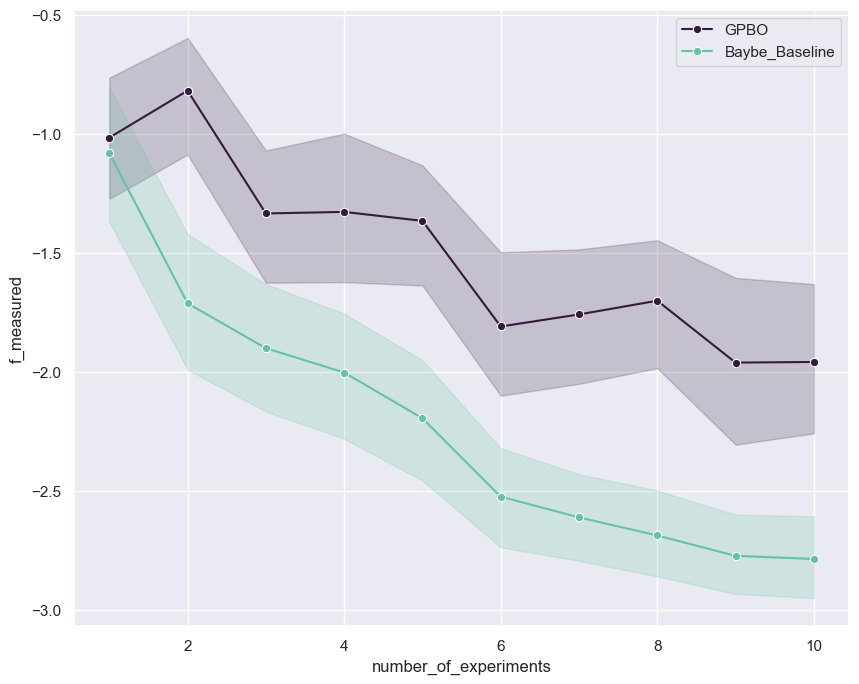

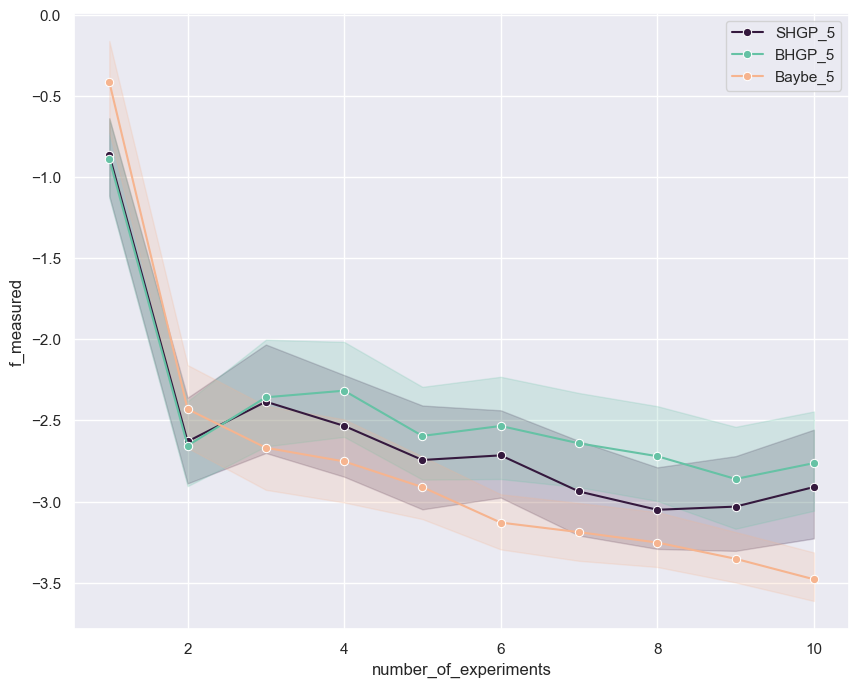

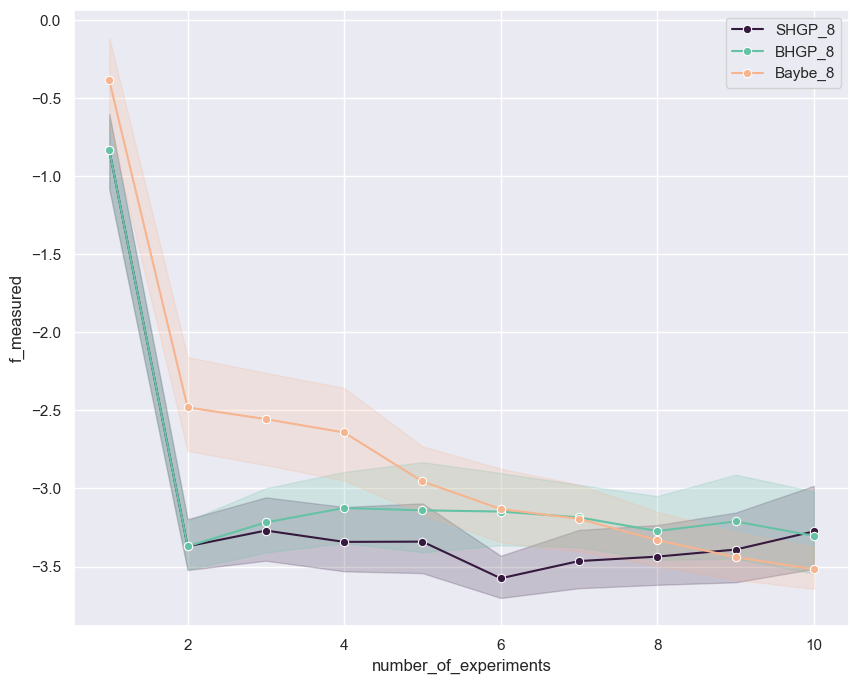

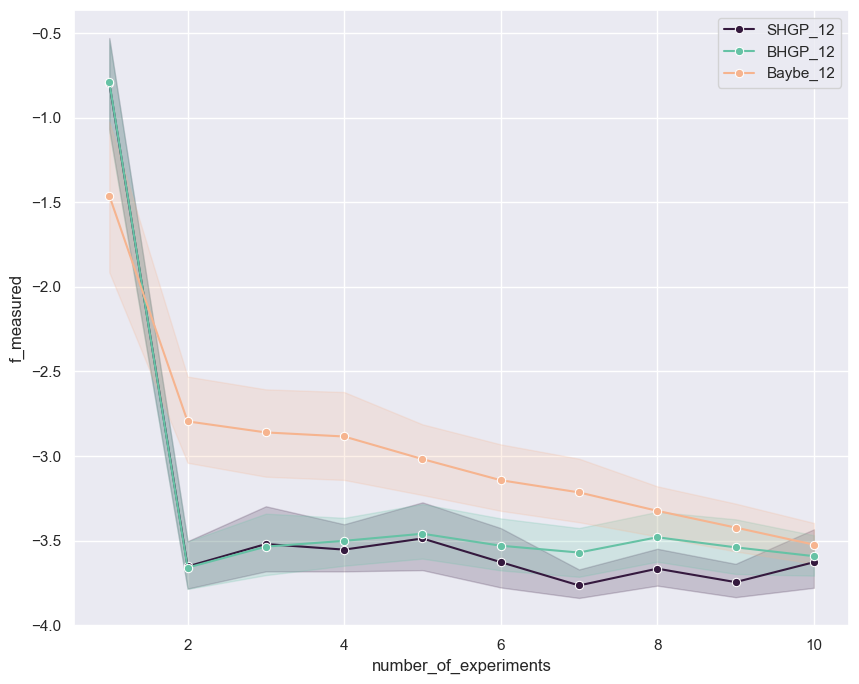

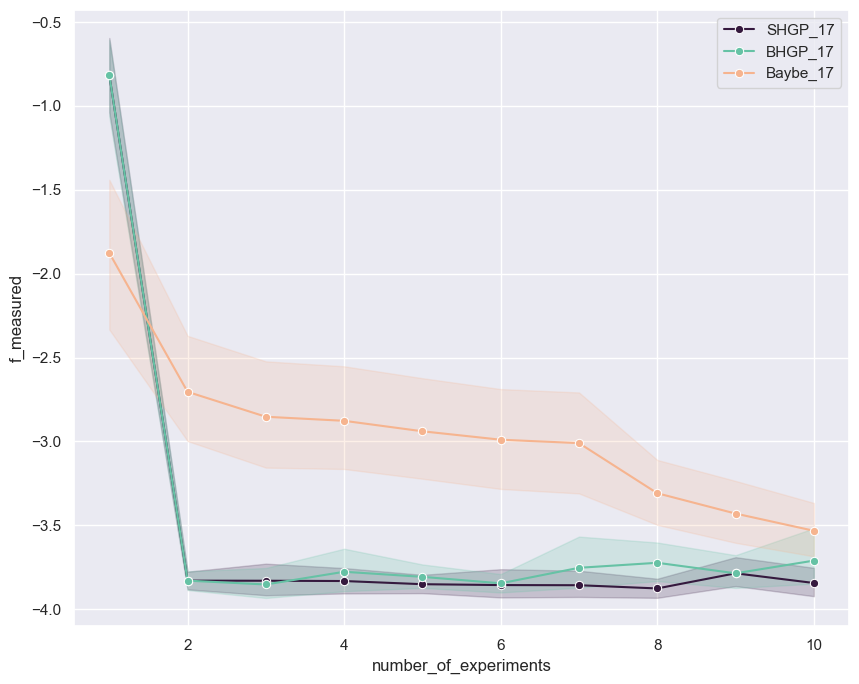

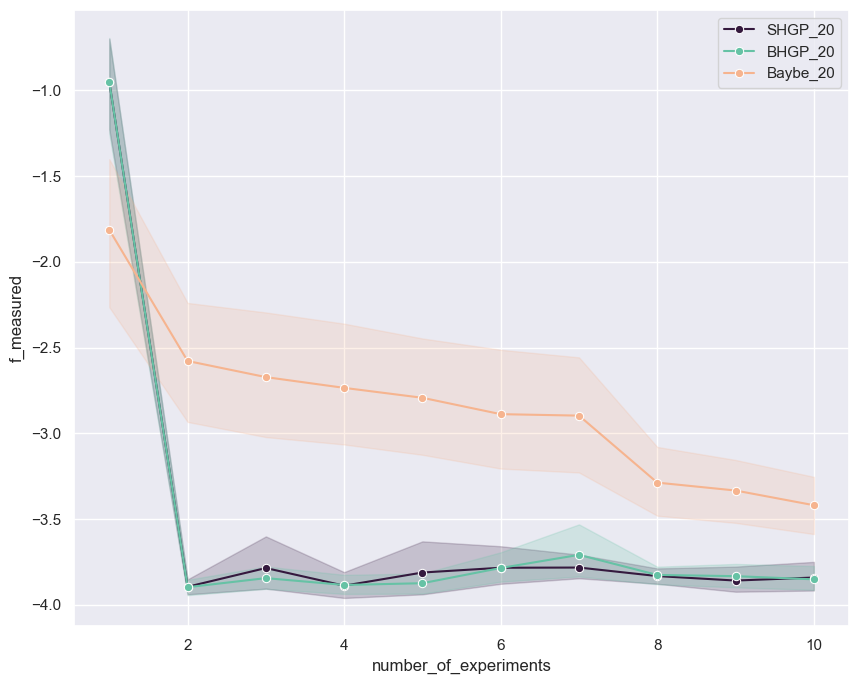

In [197]:
paded_dict3d = pad_arrays(loaded_array_b, desired_shape=(50, 10, 1))
for i in ['GPBO', '15', '24', '36', '51', '60']:
    if i == 'GPBO':
        comparison_plots_baseline(paded_dict3d, baybe_df, 'GPBO', 'Baybe_Baseline')
    else:
        comparison_plots(paded_dict3d, baybe_df, 'SHGP_'+i, 'BHGP_'+i, 'Baybe_'+str(int(int(i)/3)))

## Hartmann 6d

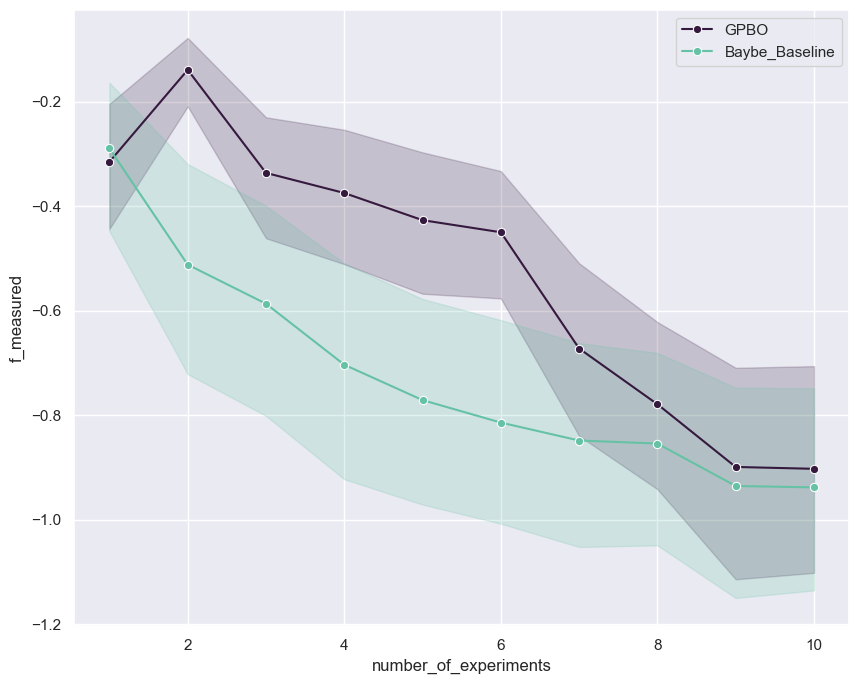

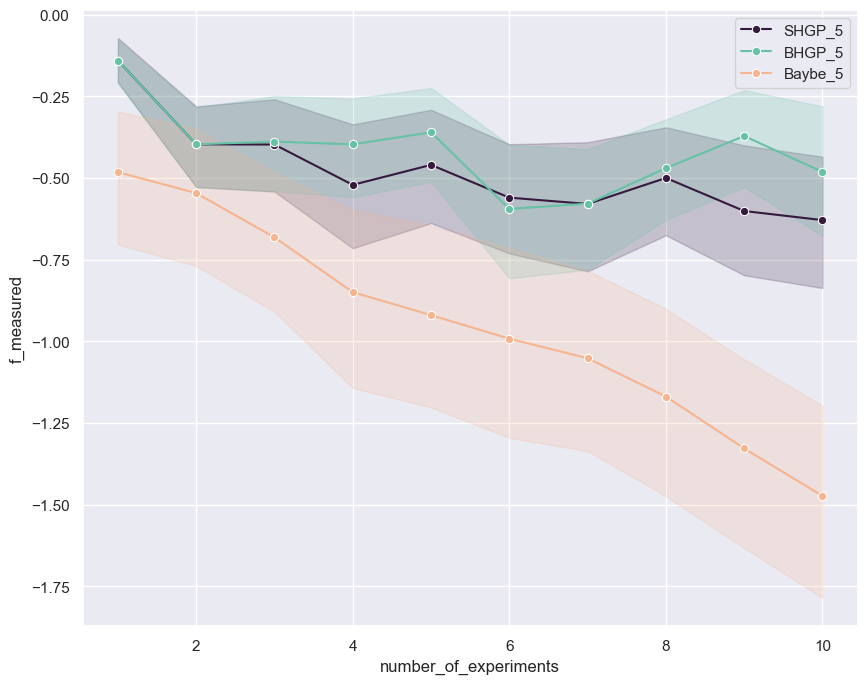

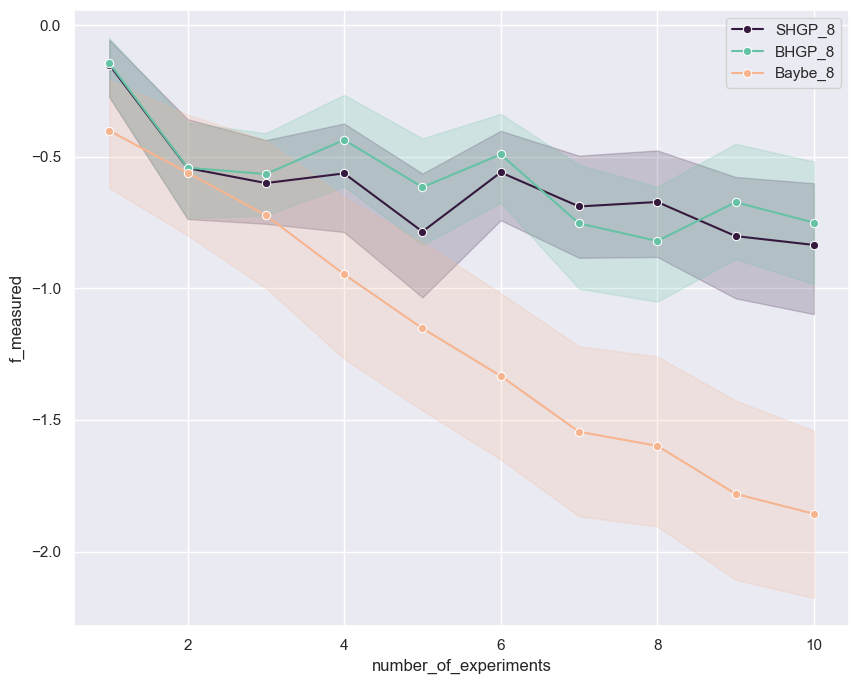

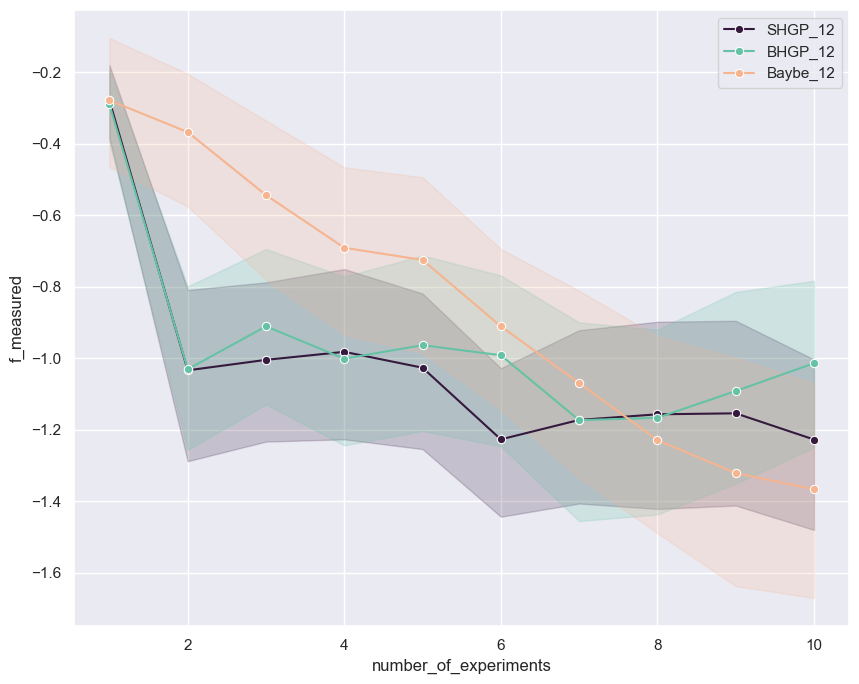

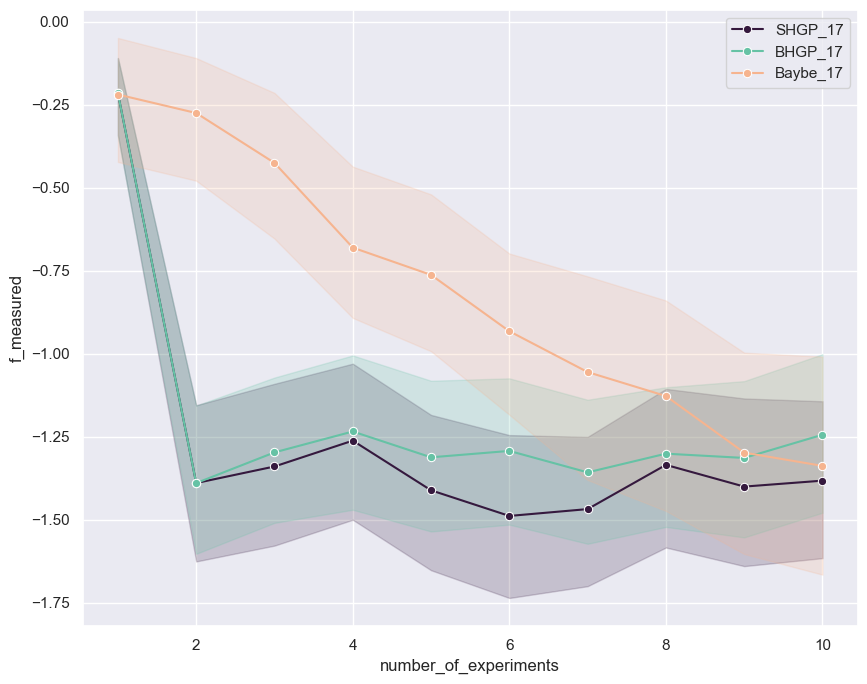

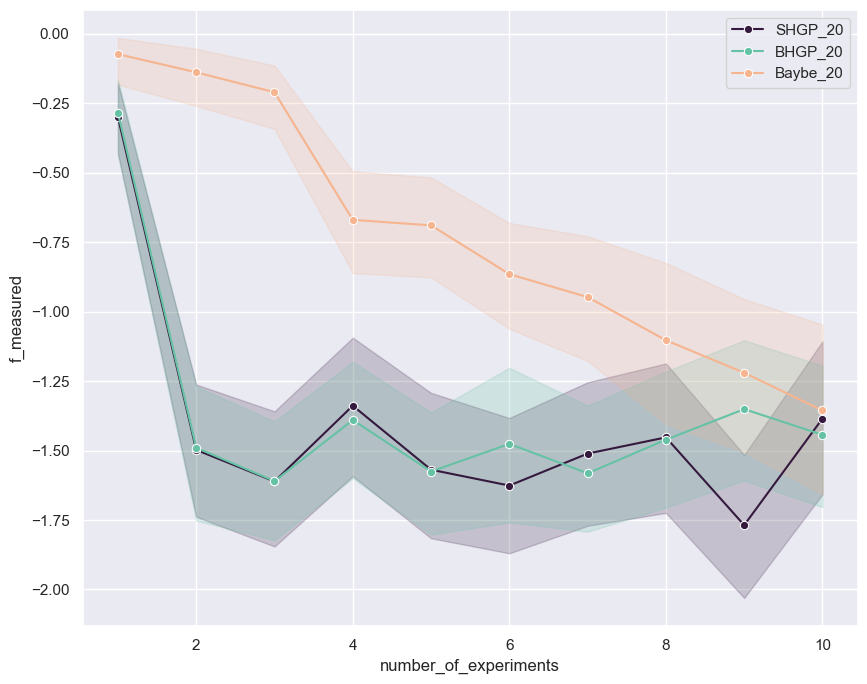

In [198]:
paded_dict6d = pad_arrays(loaded_array_c, desired_shape=(50, 10, 1))

for i in ['GPBO', '15', '24', '36', '51', '60']:
    if i == 'GPBO':
        comparison_plots_baseline(paded_dict6d, baybe_h6, 'GPBO', 'Baybe_Baseline')
    else:
        comparison_plots(paded_dict6d, baybe_h6, 'SHGP_'+i, 'BHGP_'+i, 'Baybe_'+str(int(int(i)/3)))